In [2]:
library(runjags)
library(rjags)
source("lib/DBDA2E-utilities.R")
#' Empty function to override the default behaviour of opening X windows for plots
openGraph <- function(...){
    
}
options(jupyter.plot_mimetypes = setdiff(getOption('jupyter.plot_mimetypes'), 'image/svg+xml'))

Warning message:
: package ‘runjags’ was built under R version 3.2.4Warning message:
: package ‘rjags’ was built under R version 3.2.5Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs



*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



In [3]:
theta <- 0.65
data <- 1 * (rbeta(100,theta,1-theta) > 0.5)

In [4]:
table(data)

data
 0  1 
36 64 

In [5]:
model <- "
model{
    for(i in 1:N){
        y[i] ~ dbern( theta)
    }
    theta ~ dbeta(1,1)
}
"
model.file <- tempfile("jagsmodel")
writeLines(model, con=model.file)

In [6]:
dataToJags <- list(N = length(data), y=data)

In [7]:
initToJags <- function()list(theta=runif(1))

In [8]:
jagsModel <- jags.model(file=model.file, data=dataToJags, inits = initToJags, n.chains=3, n.adapt=500)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 100
   Unobserved stochastic nodes: 1
   Total graph size: 104

Initializing model



In [9]:
update(jagsModel, n.iter=500)

In [10]:
codaSamples <- coda.samples(jagsModel, variable.names=c("theta"), n.iter=2000)

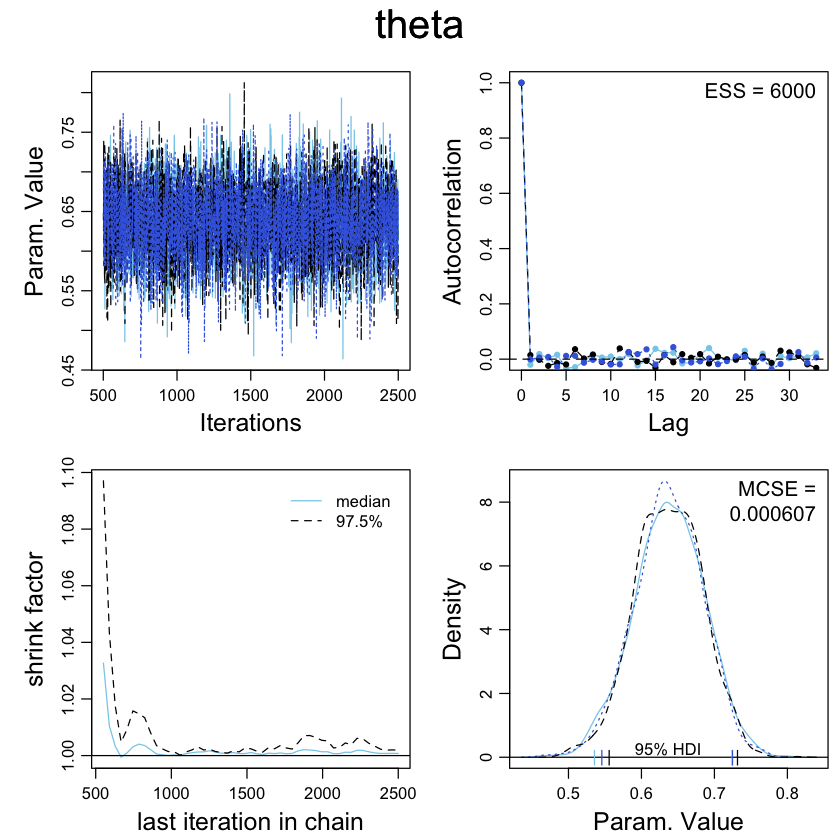

In [11]:
diagMCMC(codaObject = codaSamples, parName="theta")

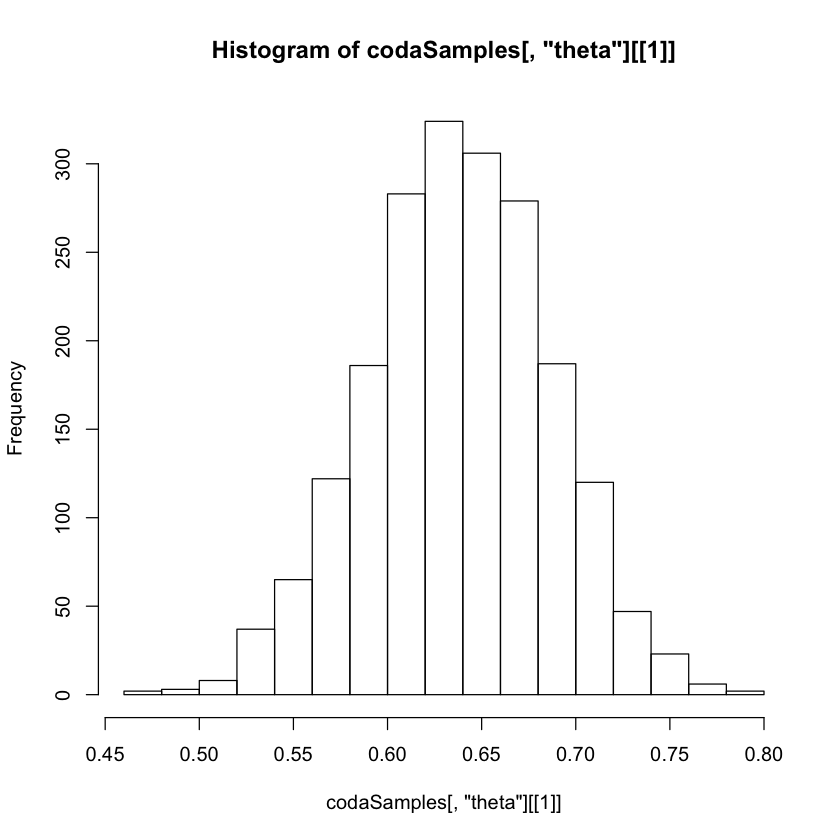

In [12]:
hist(codaSamples[,"theta"][[1]])

In [29]:
model <- "
model{
    for(i in 1:Nvals){
        y[i] ~ dbern( theta[s[i]] )
    }
    for(sIdx in 1:Nsubj){
        theta[sIdx] ~ dbeta(2,2)
    }
}
"
model.file <- tempfile("jagsmodel")
writeLines(model, con=model.file)

In [73]:
data <- data.frame(y = 1, s=c(rep(1,100),rep(2,10)))
data$y <- 1*(rnorm(nrow(data)) > 0.85)
data$y[data$s == 1] <- 1*(rnorm(sum(data$s == 1)) < 0.32)
table(data$y, data$s)

   
     1  2
  0 38  6
  1 62  4

In [74]:
dataToJags <- list(
    Nvals = nrow(data), 
    y=data$y, 
    s=data$s, 
    Nsubj=length(unique(data$s))
)
dataToJags

$Nvals
[1] 110

$y
  [1] 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1
 [38] 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0
 [75] 0 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0

$s
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2

$Nsubj
[1] 2

In [75]:
initToJags <- function(){
    thetaVals <- rep(0,length(unique(data$s)))
    for(s in unique(data$s)){
        thetaVal <- sample(data$y[data$s == s], replace=T)
        thetaVals[s] <- mean(thetaVal)
    }
    thetaVals <- thetaVals * 0.98 + 0.01
    list(theta=thetaVals)
}
initToJags()

$theta
[1] 0.6274 0.4020

In [76]:
jagsModel <- jags.model(file=model.file, data=dataToJags, inits = initToJags, n.chains=3, n.adapt=500)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 110
   Unobserved stochastic nodes: 2
   Total graph size: 228

Initializing model



In [77]:
update(jagsModel, n.iter=500)

In [78]:
codaSamples <- coda.samples(jagsModel, variable.names=c("theta[1]","theta[2]"), n.iter=2000)

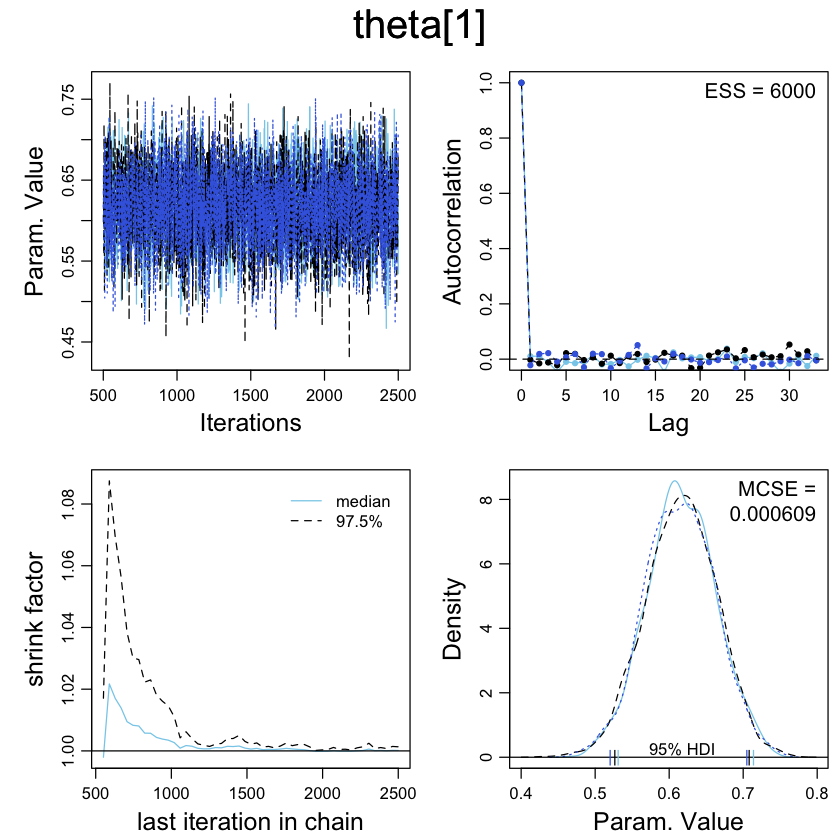

In [79]:
diagMCMC(codaObject = codaSamples, parName="theta[1]")

In [80]:
mcmcMat = as.matrix(codaSamples,chains=TRUE)
chainLength = NROW( mcmcMat )
head(mcmcMat)

CHAIN,theta[1],theta[2]
1.00000,0.60753,0.49464
1.00000,0.59696,0.41657
1.00000,0.65173,0.33982
1.00000,0.62469,0.53138
1.00000,0.65922,0.39124
1.00000,0.62312,0.44707


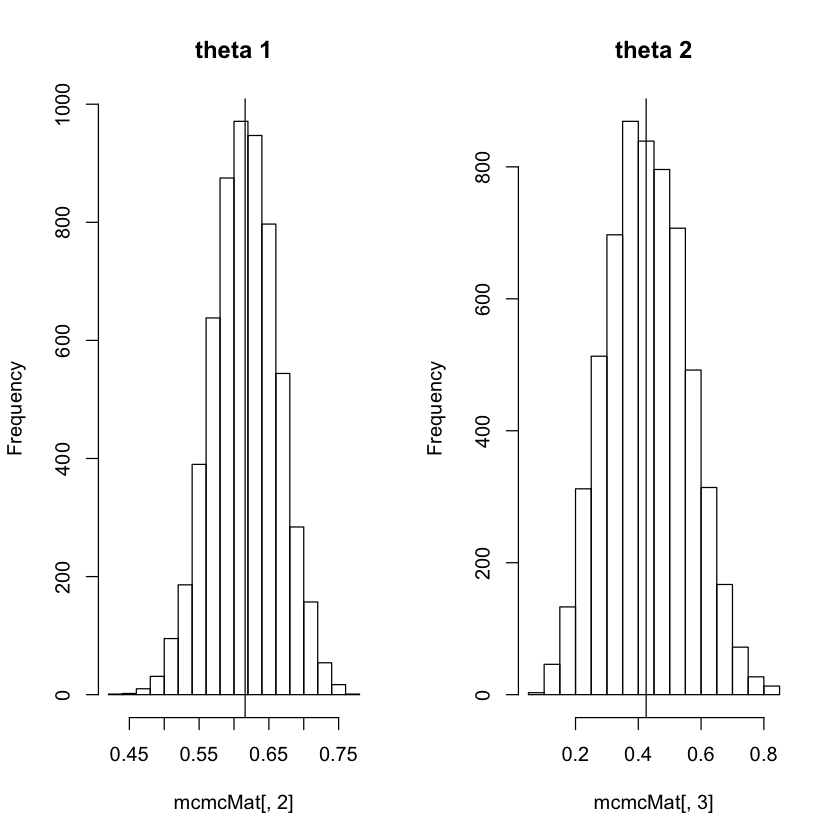

In [81]:
par(mfrow=c(1,2))
hist(mcmcMat[,2], main="theta 1")
abline(v=median(mcmcMat[,2]))
hist(mcmcMat[,3], main="theta 2")
abline(v=median(mcmcMat[,3]))

In [82]:
summarizePost(mcmcMat[,2], compVal=0.85)
summarizePost(mcmcMat[,3], compVal=0.32)

Mean        Median          Mode           ESS       HDImass 
      0.61585       0.61596       0.61279    6000.00000       0.95000 
       HDIlow       HDIhigh       CompVal PcntGtCompVal       ROPElow 
      0.52796       0.71119       0.85000       0.00000            NA 
     ROPEhigh    PcntLtROPE    PcntInROPE    PcntGtROPE 
           NA            NA            NA            NA

Mean        Median          Mode           ESS       HDImass 
      0.42888       0.42499       0.38144    6172.60000       0.95000 
       HDIlow       HDIhigh       CompVal PcntGtCompVal       ROPElow 
      0.18589       0.67746       0.32000      78.75000            NA 
     ROPEhigh    PcntLtROPE    PcntInROPE    PcntGtROPE 
           NA            NA            NA            NA